# Prise en main de TensorFlow

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

In [2]:
# Do not worry about the code below for now, it is used for plotting later
def plot_decision_boundary(pred_func, X, y):
    #from https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=-y, cmap=plt.cm.Spectral)

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

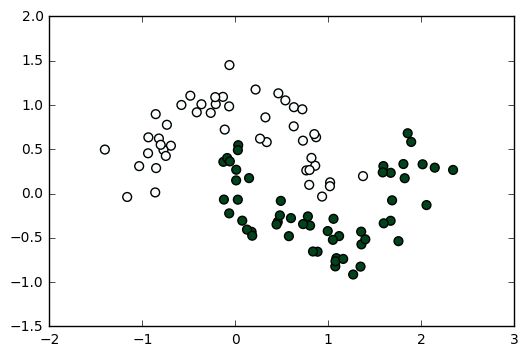

In [3]:
# Generate a dataset and plot it
np.random.seed(0)
num_samples = 300

X, y = sklearn.datasets.make_moons(num_samples, noise=0.20)

X_tr = X[:100].astype('float32')
X_val = X[100:200].astype('float32')
X_te = X[200:].astype('float32')

y_tr = y[:100].astype('int32')
y_val = y[100:200].astype('int32')
y_te = y[200:].astype('int32')

plt.scatter(X_tr[:,0], X_tr[:,1], s=40, c=y_tr, cmap=plt.cm.BuGn)

num_features = X_tr.shape[-1]
num_output = 2

In [31]:
# resets the graph, needed when initializing weights multiple times, like in this notebook
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, num_features])

# Setting up variables, these variables are weights in your network that can be update while running our graph.
# Notice, to make a hidden layer, the weights needs to have the following dimensionality
# W[number_of_units_going_in, number_of_units_going_out]
# b[number_of_units_going_out]
# in the example below we have 2 input units (num_features) and 2 output units (num_output)
# so our weights become W[2, 2], b[2]
# if we want to make a hidden layer with 100 units, we need to define the shape of the
# first weight to W[2, 100], b[2] and the shape of the second weight to W[100, 2], b[2]

# defining our initializer for our weigths from a normal distribution (mean=0, std=0.1)
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
with tf.variable_scope('l_1'): # if you run it more than once, reuse has to be True
    W_1 = tf.get_variable('W', [num_features, num_output], # change num_output to 100 for mlp
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_output], # change num_output to 100 for mlp
                          initializer=tf.constant_initializer(0.0))
# with tf. variable_scope('l_2'):
#     W_2 = tf.get_variable('W', [100, num_output],
#                           initializer=weight_initializer)
#     b_2 = tf.get_variable('b', [num_output],
#                           initializer=tf.constant_initializer(0.0))

# Setting up ops, these ops will define edges along our computational graph
# The below ops will compute a logistic regression, but can be modified to compute
# a neural network

l_1 = tf.matmul(x_pl, W_1) + b_1
# to make a hidden layer we need a nonlinearity
# l_1_nonlinear = tf.nn.relu(l_1)
# the layer before the softmax should not have a nonlinearity
# l_2 = tf.matmul(l_1_nonlinear, W_2) + b_2
y = tf.nn.softmax(l_1) # change to l_2 for MLP

In [32]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_output])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

In [33]:
# using the graph to print ops
print("operations")
operations = [op.name for op in tf.get_default_graph().get_operations()]
print(operations)
print
# variables are accessed through tensorflow
print("variables")
variables = [var.name for var in tf.all_variables()]
print(variables)

operations
['Placeholder', 'l_1/W', 'l_1/W/Initializer/truncated_normal/shape', 'l_1/W/Initializer/truncated_normal/mean', 'l_1/W/Initializer/truncated_normal/stddev', 'l_1/W/Initializer/truncated_normal/TruncatedNormal', 'l_1/W/Initializer/truncated_normal/mul', 'l_1/W/Initializer/truncated_normal', 'l_1/W/Assign', 'l_1/W/read', 'l_1/b', 'l_1/b/Initializer/Const', 'l_1/b/Assign', 'l_1/b/read', 'MatMul', 'add', 'Softmax', 'Placeholder_1', 'Log', 'mul', 'Sum/reduction_indices', 'Sum', 'Neg', 'Const', 'Mean']
variables
['l_1/W:0', 'l_1/b:0']


In [34]:
# Defining our optimizer (try with different optimizers here!)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# Computing our gradients
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# Applying the gradients
train_op = optimizer.apply_gradients(grads_and_vars)

# Notice, alternatively you can use train_op = optimizer.minimize(crossentropy)
# instead of the three steps above

In [35]:
# making a one-hot encoded vector of correct (1) and incorrect (0) predictions
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# averaging the one-hot encoded vector
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fca484cdc88>>
Traceback (most recent call last):
  File "/home/francois/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 522, in __del__
    self.close()
  File "/home/francois/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1262, in close
    self._default_session.__exit__(None, None, None)
  File "/home/francois/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/home/francois/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3536, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


Epoch 0, Train Cost: 0.700	Val Cost: 0.672	 Val acc: 0.670
Epoch 100, Train Cost: 0.353	Val Cost: 0.371	 Val acc: 0.820
Epoch 200, Train Cost: 0.325	Val Cost: 0.346	 Val acc: 0.830
Epoch 300, Train Cost: 0.315	Val Cost: 0.338	 Val acc: 0.830
Epoch 400, Train Cost: 0.309	Val Cost: 0.334	 Val acc: 0.830
Epoch 500, Train Cost: 0.307	Val Cost: 0.333	 Val acc: 0.820
Epoch 600, Train Cost: 0.305	Val Cost: 0.332	 Val acc: 0.810
Epoch 700, Train Cost: 0.304	Val Cost: 0.332	 Val acc: 0.800
Epoch 800, Train Cost: 0.303	Val Cost: 0.332	 Val acc: 0.800
Epoch 900, Train Cost: 0.303	Val Cost: 0.332	 Val acc: 0.800

Test Cost: 0.272	Test Accuracy: 0.870


(<matplotlib.text.Text at 0x7fca48593b70>,
 <matplotlib.text.Text at 0x7fca486cb908>)

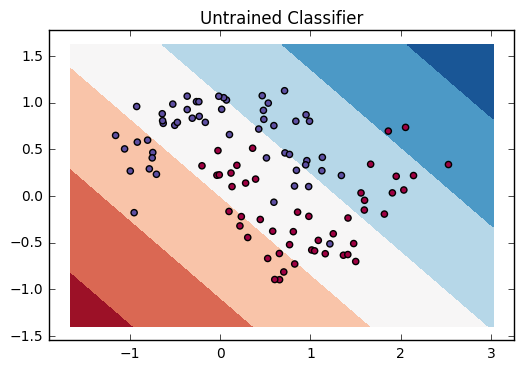

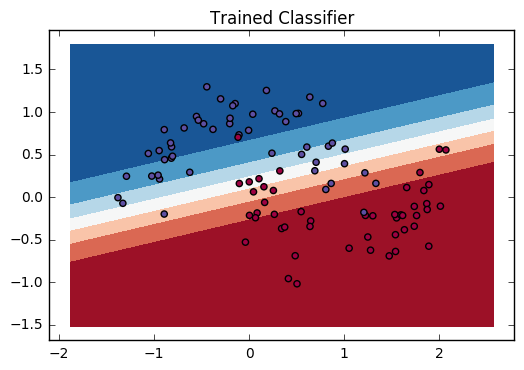

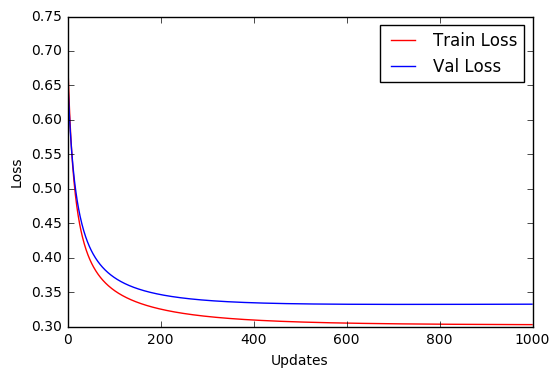

In [37]:
# defining a function to make predictions using our classifier
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

# Training loop
num_epochs = 1000

train_cost, val_cost, val_acc = [],[],[]
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    
    # initializing all variables
    init = tf.initialize_all_variables()
    sess.run(init)
    plot_decision_boundary(lambda x: pred(x, sess), X_val, y_val)
    plt.title("Untrained Classifier")
    for e in range(num_epochs):
        ### TRAINING ###
        # what to feed to our train_op
        # notice we onehot encode our predictions to change shape from (batch,) -> (batch, num_output)
        feed_dict_train = {x_pl: X_tr, y_: onehot(y_tr, num_output)}
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        # running the train_op
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        # what to feed our accuracy op
        feed_dict_valid = {x_pl: X_val, y_: onehot(y_val, num_output)}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # running the validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f"\
                  %(e, train_cost[-1],val_cost[-1],val_acc[-1]))

    ### TESTING ###
    # what to feed our accuracy op
    feed_dict_test = {x_pl: X_te, y_: onehot(y_te, num_output)}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # running the validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    print ("\nTest Cost: %0.3f\tTest Accuracy: %0.3f"%(test_cost, test_acc))
    
    # For plotting purposes
    plot_decision_boundary(lambda x: pred(x, sess), X_te, y_te)

# notice: we do not need to use the session environment anymore, so returning from it.
plt.title("Trained Classifier")

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

## Maintenant faisons la même chose avec une couche cachée

In [4]:
# resets the graph, needed when initializing weights multiple times, like in this notebook
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, num_features])

# Setting up variables, these variables are weights in your network that can be update while running our graph.
# Notice, to make a hidden layer, the weights needs to have the following dimensionality
# W[number_of_units_going_in, number_of_units_going_out]
# b[number_of_units_going_out]
# in the example below we have 2 input units (num_features) and 2 output units (num_output)
# so our weights become W[2, 2], b[2]
# if we want to make a hidden layer with 100 units, we need to define the shape of the
# first weight to W[2, 100], b[2] and the shape of the second weight to W[100, 2], b[2]


# defining our initializer for our weigths from a normal distribution (mean=0, std=0.1)
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
with tf.variable_scope('l_1'): # if you run it more than once, reuse has to be True
    W_1 = tf.get_variable('W', [num_features, 100], # change num_output to 100 for mlp
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [100], # change num_output to 100 for mlp
                          initializer=tf.constant_initializer(0.0))
with tf. variable_scope('l_2'):
    W_2 = tf.get_variable('W', [100, num_output],
                           initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_output],
                           initializer=tf.constant_initializer(0.0))
    
#with tf. variable_scope('l_3'):
#    W_3 = tf.get_variable('W', [num_hidden, num_output],
#                           initializer=weight_initializer)
#    b_3 = tf.get_variable('b', [num_output],
#                           initializer=tf.constant_initializer(0.0))

# Setting up ops, these ops will define edges along our computational graph
# The below ops will compute a logistic regression, but can be modified to compute
# a neural network

l_1 = tf.matmul(x_pl, W_1) + b_1
# to make a hidden layer we need a nonlinearity
l_1_nonlinear = tf.nn.relu(l_1)
# the layer before the softmax should not have a nonlinearity
l_2 = tf.matmul(l_1_nonlinear, W_2) + b_2
#l_2_nonlinear = tf.nn.relu(l_2)
#l_3 = tf.matmul(l_2_nonlinear, W_3) + b_3
y = tf.nn.softmax(l_2) # change to l_2 for MLP

In [5]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_output])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

In [16]:
# Defining our optimizer (try with different optimizers here!)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.001)

# Computing our gradients
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# Applying the gradients
train_op = optimizer.apply_gradients(grads_and_vars)

# Notice, alternatively you can use train_op = optimizer.minimize(crossentropy)
# instead of the three steps above

In [17]:
# making a one-hot encoded vector of correct (1) and incorrect (0) predictions
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# averaging the one-hot encoded vector
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Epoch 0, Train Cost: 0.695	Val Cost: 0.685	 Val acc: 0.660
Epoch 100, Train Cost: 0.325	Val Cost: 0.345	 Val acc: 0.830
Epoch 200, Train Cost: 0.296	Val Cost: 0.325	 Val acc: 0.810
Epoch 300, Train Cost: 0.288	Val Cost: 0.320	 Val acc: 0.810
Epoch 400, Train Cost: 0.281	Val Cost: 0.316	 Val acc: 0.840
Epoch 500, Train Cost: 0.275	Val Cost: 0.312	 Val acc: 0.840
Epoch 600, Train Cost: 0.267	Val Cost: 0.306	 Val acc: 0.860
Epoch 700, Train Cost: 0.258	Val Cost: 0.298	 Val acc: 0.860
Epoch 800, Train Cost: 0.244	Val Cost: 0.286	 Val acc: 0.860
Epoch 900, Train Cost: 0.226	Val Cost: 0.270	 Val acc: 0.880

Test Cost: 0.188	Test Accuracy: 0.940


(<matplotlib.text.Text at 0x7f37bbdc1860>,
 <matplotlib.text.Text at 0x7f37bbdca978>)

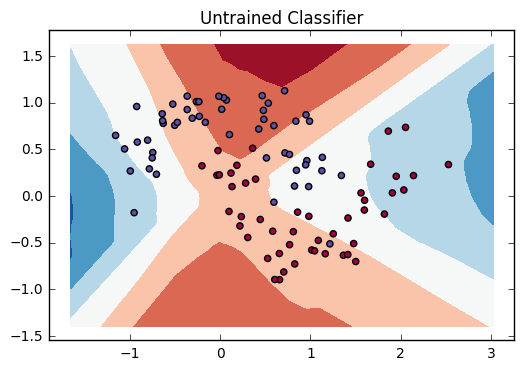

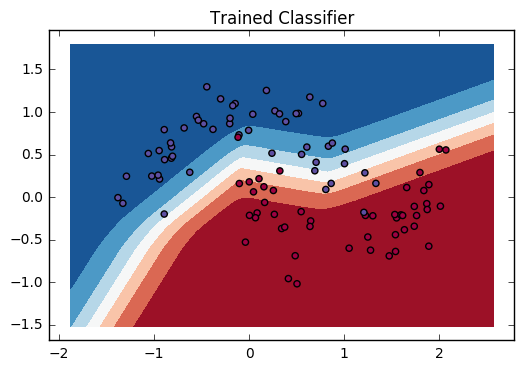

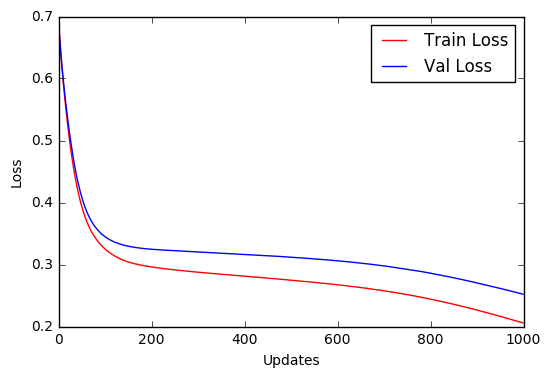

In [18]:
# defining a function to make predictions using our classifier
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

# Training loop
num_epochs = 1000

train_cost, val_cost, val_acc = [],[],[]
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    
    # initializing all variables
    init = tf.initialize_all_variables()
    sess.run(init)
    plot_decision_boundary(lambda x: pred(x, sess), X_val, y_val)
    plt.title("Untrained Classifier")
    for e in range(num_epochs):
        ### TRAINING ###
        # what to feed to our train_op
        # notice we onehot encode our predictions to change shape from (batch,) -> (batch, num_output)
        feed_dict_train = {x_pl: X_tr, y_: onehot(y_tr, num_output)}
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        # running the train_op
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        # what to feed our accuracy op
        feed_dict_valid = {x_pl: X_val, y_: onehot(y_val, num_output)}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # running the validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f"\
                  %(e, train_cost[-1],val_cost[-1],val_acc[-1]))

    ### TESTING ###
    # what to feed our accuracy op
    feed_dict_test = {x_pl: X_te, y_: onehot(y_te, num_output)}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # running the validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    print ("\nTest Cost: %0.3f\tTest Accuracy: %0.3f"%(test_cost, test_acc))
    
    # For plotting purposes
    plot_decision_boundary(lambda x: pred(x, sess), X_te, y_te)

# notice: we do not need to use the session environment anymore, so returning from it.
plt.title("Trained Classifier")

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')